[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chhsiao93/research/blob/main/VAE/VAE.ipynb)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        # Kullback-Leibler Divergence
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
df_stft = pd.read_csv('stft.csv')
station_summary = pd.read_csv('summary.csv')
station_summary['RSNID'] = np.core.defchararray.add(np.array(['RSN']*202),station_summary['RSNID'].values.astype(str))
station_summary.head()
df_stft = station_summary.merge(df_stft, 'left', on='RSNID')

In [ ]:
# freq range from 0 to 20 Hz
f_max = 40
# time range from 0 to 148 sec
t_max = 148
# rescale to 0 to 1
rescale = True

stft = df_stft.iloc[:,18:].values


if rescale:
  scaler = MinMaxScaler()
  stft = scaler.fit_transform(stft.transpose()).transpose()

stft = stft.reshape(404, 201, 151)
stft = stft[:, :f_max, :t_max]
stft.shape

(404, 40, 148)

In [ ]:
X_all = stft
y_all = df_stft.iloc[:,:18]
X_train, X_test, y_train, y_test = train_test_split(stft, df_stft.iloc[:,:18], test_size=0.2, random_state=0)

Encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(40, 148, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 148, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 20, 74, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 10, 37, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 23680)        0           ['conv2d_1[0][0]']         

Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(10 * 37 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((10, 37, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 23680)             71040     
                                                                 
 reshape (Reshape)           (None, 10, 37, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 74, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 40, 148, 32)      18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 40, 148, 1)       289 

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(np.expand_dims(X_train, -1), epochs=30, batch_size=32)

Epoch 1/30
11/11 [==============================] - 53s 32ms/step - loss: 3983.0572 - reconstruction_loss: 3659.2737 - kl_loss: 154.5992
Epoch 2/30
11/11 [==============================] - 0s 28ms/step - loss: 1911.6926 - reconstruction_loss: 1419.1803 - kl_loss: 88.5052
Epoch 3/30
11/11 [==============================] - 0s 25ms/step - loss: 887.2511 - reconstruction_loss: 717.5320 - kl_loss: 40.7143
Epoch 4/30
11/11 [==============================] - 0s 25ms/step - loss: 571.1392 - reconstruction_loss: 566.5699 - kl_loss: 2.1740
Epoch 5/30
11/11 [==============================] - 0s 25ms/step - loss: 523.3965 - reconstruction_loss: 519.6368 - kl_loss: 0.8129
Epoch 6/30
11/11 [==============================] - 0s 25ms/step - loss: 501.1322 - reconstruction_loss: 494.6612 - kl_loss: 0.3766
Epoch 7/30
11/11 [==============================] - 0s 26ms/step - loss: 489.3482 - reconstruction_loss: 490.2623 - kl_loss: 0.1108
Epoch 8/30
11/11 [==============================] - 0s 25ms/step - 

In [ ]:
keras.backend.clear_session()

[[-0.54860705  0.08969019]]


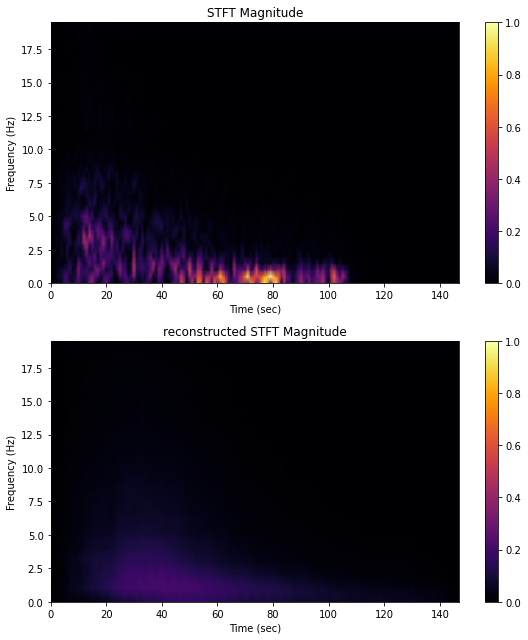

In [ ]:
num = 100

t = np.arange(t_max)
f = np.linspace(0, 100, num=201)[:f_max]

fig, axes = plt.subplots(2,1, figsize=(8,9))
#cmap = plt.colormaps('inferno')
im = axes[0].pcolormesh(t, f, stft[num], vmin=0, shading='gouraud', cmap='inferno')
axes[0].set_title('STFT Magnitude')
axes[0].set_ylabel('Frequency (Hz)')
axes[0].set_xlabel('Time (sec)')
fig.colorbar(im, ax=axes[0])

mean, _, _ = vae.encoder.predict(stft[num:num+1])
print(mean)
pred = vae.decoder.predict(mean)

im = axes[1].pcolormesh(t, f, pred.reshape(40,148), vmin=0, vmax=1, shading='gouraud', cmap='inferno')
axes[1].set_title('reconstructed STFT Magnitude')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_xlabel('Time (sec)')
fig.colorbar(im, ax=axes[1])

plt.tight_layout()

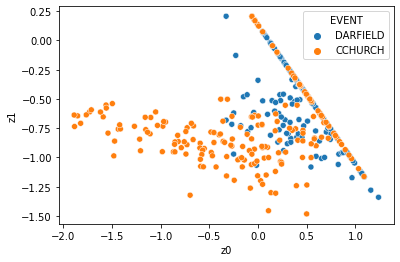

In [ ]:
def plot_label_clusters(vae, x, y, key):
  # display a 2D plot of the digit classes in the latent space
  z_mean, _, _ = vae.encoder.predict(x)
  df = y.copy()
  df['z0'] = z_mean[:,0]
  df['z1'] = z_mean[:,1]
  sns.scatterplot(data=df, x="z0", y="z1", hue=key)
plot_label_clusters(vae, X_all, y_all, 'EVENT')

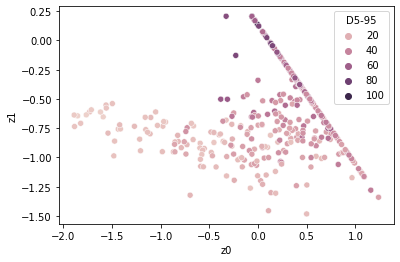

In [ ]:
plot_label_clusters(vae, X_all, y_all, 'D5-95')

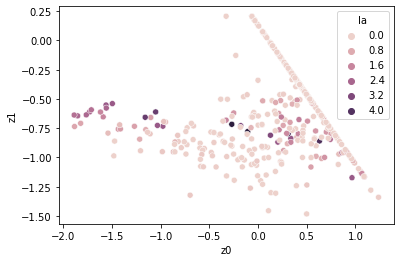

In [ ]:
plot_label_clusters(vae, X_all, y_all, 'Ia')

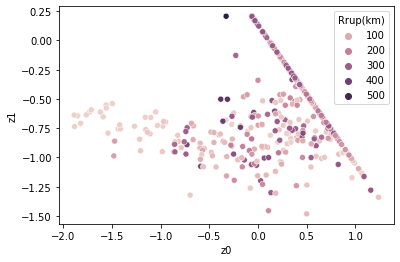

In [ ]:
plot_label_clusters(vae, X_all, y_all, 'Rrup(km)')

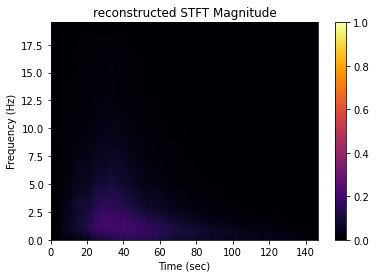

In [ ]:
pred = vae.decoder.predict([[-1, -1]])

im = plt.pcolormesh(t, f, pred.reshape(40,148), vmin=0, vmax=1, shading='gouraud', cmap='inferno')
plt.title('reconstructed STFT Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.colorbar(im)